<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/OBIWAN_Rx_Fire_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install requests ipywidgets


In [3]:
import ee
import geemap

In [4]:
# Authenticate and initialize Earth Engine
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

# ESA_CCI_AGB approach

In [11]:
palette = ["#C6ECAE","#A1D490","#7CB970","#57A751","#348E32",
           "#267A29","#176520","#0C4E15","#07320D","#031807"]

# Create a map
Map = geemap.Map(center=[0, 0], zoom=2)

# Load AGB ImageCollection
agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')

# Add 2020 AGB layer
agb_2020 = agb.filterDate('2019-01-01', '2021-01-01').first().select(['AGB'])
Map.addLayer(agb_2020, {'min':1, 'max':450, 'palette': palette}, 'Above Ground Biomass 2020')


EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# print("EIA_CS1:", EIA_CS1.size().getInfo())
# print("EIA_CS2:", EIA_CS2.size().getInfo())
# print("EIA_CS3:", EIA_CS3.size().getInfo())

Map.addLayer(EIA_CS1, {}, "EIA_CS1")
Map.addLayer(EIA_CS2, {}, "EIA_CS2")
Map.addLayer(EIA_CS3, {}, "EIA_CS3")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [12]:
# import ee
# import geemap

# # Initialize the Earth Engine module
# ee.Initialize()

# Define palette
# palette = ["#C6ECAE","#A1D490","#7CB970","#57A751","#348E32",
#            "#267A29","#176520","#0C4E15","#07320D","#031807"]

# # Create a map
# Map = geemap.Map(center=[0, 0], zoom=2)

# # Load AGB ImageCollection
# agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')

# # Add 2020 AGB layer
# agb_2020 = agb.filterDate('2019-01-01', '2021-01-01').first().select(['AGB'])
# Map.addLayer(agb_2020, {'min':1, 'max':450, 'palette': palette}, 'Above Ground Biomass 2020')

# Map


# # Load feature collections
# EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
# EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
# EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# # print("EIA_CS1:", EIA_CS1.size().getInfo())
# # print("EIA_CS2:", EIA_CS2.size().getInfo())
# # print("EIA_CS3:", EIA_CS3.size().getInfo())

# Map.addLayer(EIA_CS1, {}, "EIA_CS1")
# Map.addLayer(EIA_CS2, {}, "EIA_CS2")
# Map.addLayer(EIA_CS3, {}, "EIA_CS3")

# Compute pixel area in hectares
pixel_area_ha = ee.Image.pixelArea().divide(10000)

# Biomass in Mg (tons) per pixel for 2019
agb_2019 = agb.filterDate('2019-01-01', '2019-01-02').first().select(['AGB'])

# Get projection info
proj = agb_2019.projection()
# print('Projection:', proj.getInfo())
# print('Nominal scale (m):', proj.nominalScale().getInfo())

# Multiply by pixel area to get Mg per pixel
agb_Mg_per_pixel = agb_2019.multiply(pixel_area_ha)

# Convert Mg to short tons
agb_tons_per_pixel = agb_Mg_per_pixel.multiply(1.10231)

# Function to sum biomass per polygon
def add_total_biomass(fc, name):
    reduced = agb_tons_per_pixel.reduceRegions(
        collection=fc,
        reducer=ee.Reducer.sum(),
        scale=100
    )
    reduced = reduced.map(lambda f: f.set({
        'Source': name,
        'Total_AGB_tons': f.get('sum')
    }))
    return reduced

# Apply function to feature collections
results1 = add_total_biomass(EIA_CS1, 'EIA_CS1')
results2 = add_total_biomass(EIA_CS2, 'EIA_CS2')
results3 = add_total_biomass(EIA_CS3, 'EIA_CS3')

# Merge results
# all_results = results1.merge(results2).merge(results3)

# print('All Results with total biomass (tons):', all_results.size().getInfo())

# # Export to Google Drive
# task = ee.batch.Export.table.toDrive(
#     collection=all_results,
#     description='EIA_AGB_total_tons_2019',
#     fileFormat='CSV'
# )
# task.start()

# Display the map
# Map


In [13]:
all_results = results1.merge(results2).merge(results3)

print('All Results with total biomass (tons):', all_results.size().getInfo())

All Results with total biomass (tons): 3


In [14]:
all_results

In [15]:
# Convert to GeoPandas GeoDataFrame
gdf = geemap.ee_to_gdf(all_results)

# Display the head of the GeoDataFrame
print(gdf.head())
# You can also plot the GeoDataFrame
# gdf.plot()

                                            geometry  ACCURACY   CN COMMENTS  \
0  POLYGON ((-87.49023 32.99817, -87.49002 32.998...       0.0                 
1  POLYGON ((-86.96387 32.77259, -86.96354 32.769...       NaN                 
2  POLYGON ((-87.34536 32.97872, -87.34433 32.978...      12.0  NaN      NaN   

  COMPLEXNAM DATASOURCE    DBSOURCEDA DBSOURCEID    DISCOVERYD  \
0                    02  1.750576e+12       0801  1.549008e+12   
1                    02  1.750921e+12       0801  1.554188e+12   
2        NaN        NaN           NaN        NaN           NaN   

                 FEATURECAT  ...  STATE_ABBR SUBUNIT                 SUID  \
0  Final Wildfire Perimeter  ...         NaN     NaN                  NaN   
1  Final Wildfire Perimeter  ...         NaN     NaN                  NaN   
2                       NaN  ...          AL     001  0801041111001200001   

        SUID_CN  TREATMENT1      TREATMENT_                UK  \
0           NaN         NaN             

# OBIWAN approach

In [16]:
import ee, json


# Your FeatureCollections
EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# Convert to GeoJSON (Python dicts)
geojson_fc1 = EIA_CS1.getInfo()
geojson_fc2 = EIA_CS2.getInfo()
geojson_fc3 = EIA_CS3.getInfo()


In [ ]:
# EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
# EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
# EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# geojson_fc1 = EIA_CS1.getInfo()
# geojson_fc2 = EIA_CS2.getInfo()
# geojson_fc3 = EIA_CS3.getInfo()


# import json

# with open("EIA_CS1.json", "w") as f:
#     json.dump(geojson_fc1, f)

# with open("EIA_CS2.json", "w") as f:
#     json.dump(geojson_fc2, f)

# with open("EIA_CS3.json", "w") as f:
#     json.dump(geojson_fc3, f)


In [ ]:
# import json

# # Load the saved file
# with open("/content/EIA_CS1.json", "r") as f:
#     EIA_CS1_json = json.load(f)

# # Now "data" is a Python dict
# print(type(EIA_CS1_json))
# print(EIA_CS1_json.keys())   # Should show something like: ['type', 'features']



# with open("/content/EIA_CS2.json", "r") as f:
#     EIA_CS2_json = json.load(f)


# with open("/content/EIA_CS3.json", "r") as f:
#     EIA_CS3_json = json.load(f)

<class 'dict'>
dict_keys(['type', 'columns', 'version', 'id', 'properties', 'features'])


In [17]:
import requests

class ObiwanClient:
    def __init__(self, base_url="https://obiwan-alabama-api-5026633953.us-west1.run.app"):
        self.base_url = base_url.rstrip('/')

    def estimate_biomass_stock(self, year, geojson_payload, calibration_flag=False):
        # New endpoint (shorter path)
        endpoint = f"{self.base_url}/estimate_biomass_state_geojson/{year}"
        params = {"use_calibration": str(calibration_flag).lower()}  # true/false
        headers = {"Content-Type": "application/json"}

        response = requests.post(endpoint, params=params, json=geojson_payload, headers=headers)
        response.raise_for_status()
        return response.json()


In [18]:
client = ObiwanClient()

year = 2019
calibration_flag = True  # or True

In [19]:
import pandas as pd

In [23]:
estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
# estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
# estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
print(estimates_fc1)
# pd.DataFrame([estimates_fc1])
# pd.DataFrame([estimates_fc2])
# pd.DataFrame([estimates_fc3])

{'AGBD': 201.2545406801871, 'area': 5152478.115234375, 'asset_version': '1.0', 'stdAGBD': 2.620773988024994, 'use_calibration': True, 'year': 2019}


In [27]:
estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
print(estimates_fc1)

{'AGBD': 201.2545406801871, 'area': 5152478.115234375, 'asset_version': '1.0', 'stdAGBD': 2.620773988024994, 'use_calibration': True, 'year': 2019}


In [24]:
estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
print(estimates_fc2)

{'AGBD': 198.77709747704773, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 3.0370967908580146, 'use_calibration': True, 'year': 2019}


In [28]:
estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
print(estimates_fc2)

{'AGBD': 198.77709747704773, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 3.0370967908580146, 'use_calibration': True, 'year': 2019}


In [26]:
pd.DataFrame([estimates_fc1])
pd.DataFrame([estimates_fc2])
pd.DataFrame([estimates_fc3])

,AGBD,area,asset_version,stdAGBD,use_calibration,year
0,170.233926,4.160505e+06,1.0,2.867049,True,2019


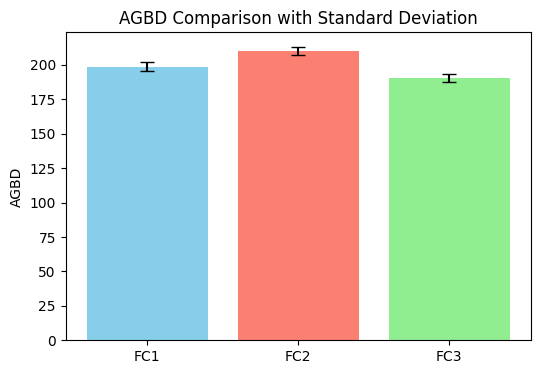

In [ ]:
import matplotlib.pyplot as plt

# Example dictionaries
estimates_fc1 = {'AGBD': 198.777, 'area': 10821259.33, 'asset_version': '1.0', 'stdAGBD': 3.037, 'use_calibration': True, 'year': 2019}
estimates_fc2 = {'AGBD': 210.123, 'area': 10821259.33, 'asset_version': '1.0', 'stdAGBD': 2.89, 'use_calibration': True, 'year': 2019}
estimates_fc3 = {'AGBD': 190.456, 'area': 10821259.33, 'asset_version': '1.0', 'stdAGBD': 3.12, 'use_calibration': True, 'year': 2019}

# Extract AGBD and stdAGBD values
agb_values = [estimates_fc1['AGBD'], estimates_fc2['AGBD'], estimates_fc3['AGBD']]
std_values = [estimates_fc1['stdAGBD'], estimates_fc2['stdAGBD'], estimates_fc3['stdAGBD']]

# Labels for dictionaries
labels = ['FC1', 'FC2', 'FC3']

# Plotting with error bars
plt.figure(figsize=(6,4))
plt.bar(labels, agb_values, yerr=std_values, capsize=5, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel('AGBD')
plt.title('AGBD Comparison with Standard Deviation')
plt.show()
